# Uma análise de eficiencia entre *K-means* e *bisecting K-means* 

A idéia deste projeto é realizar um *benchmark* dos algoritmos K-means e *bisecting K-means* nos *DataSets* Iris e HertDesies.



In [1]:
from sklearn import metrics
from time import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import random as rd

filepath_trettel = '/home/trettel/Documents/projects/DATALAB/datasets/Iris_Data.csv'
filepath_eric = '/home/grayjack/MySources/WorkshopML/data/Iris_Data.csv'

In [2]:
data = pd.read_csv(filepath_eric)
print(data.describe())

       sepal_length  sepal_width  petal_length  petal_width
count    150.000000   150.000000    150.000000   150.000000
mean       5.843333     3.054000      3.758667     1.198667
std        0.828066     0.433594      1.764420     0.763161
min        4.300000     2.000000      1.000000     0.100000
25%        5.100000     2.800000      1.600000     0.300000
50%        5.800000     3.000000      4.350000     1.300000
75%        6.400000     3.300000      5.100000     1.800000
max        7.900000     4.400000      6.900000     2.500000


In [3]:
data.groupby('species').agg(['mean', 'median'])
data.groupby('species').agg([np.mean, np.median])

sepal_length        sepal_width        petal_length         \
                        mean median        mean median         mean median   
species                                                                      
Iris-setosa            5.006    5.0       3.418    3.4        1.464   1.50   
Iris-versicolor        5.936    5.9       2.770    2.8        4.260   4.35   
Iris-virginica         6.588    6.5       2.974    3.0        5.552   5.55   

                petal_width         
                       mean median  
species                             
Iris-setosa           0.244    0.2  
Iris-versicolor       1.326    1.3  
Iris-virginica        2.026    2.0

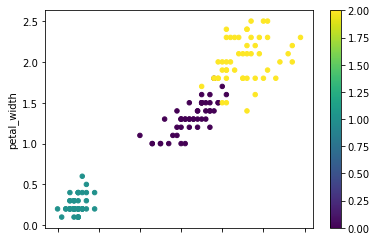

In [4]:
num = {val:i for i,val in enumerate(set(data.species))}
y_true = [num[item] for item in data.species]

data.plot.scatter(x="petal_length", y="petal_width", c=y_true, colormap='viridis')

In [5]:
def plotter(doc, ks, label):
    X,Y = zip(*doc)
    kx,ky = zip(*ks)

    plt.scatter(x=X,y=Y, marker='o', c=label)
    plt.scatter(x=kx, y=ky, marker='x', color='black', s=150)


In [6]:
def euclidianDistance(p1, p2):
    return math.sqrt( (p1[0] - p2[0])**2 + (p1[1] - p2[1])**2 )


In [7]:
MAX_ITER = 15
def goCondition(old_centroids, curr_centroids, itter):
    if itter >= MAX_ITER: return False    
    
    ctd = 0
    for old_centroid,curr_centroid in zip(old_centroids,curr_centroids):
        if abs(old_centroid[0]-curr_centroid[0]) <= 0.001 and\
           abs(old_centroid[1]-curr_centroid[1]) <= 0.001:
               ctd += 1
    if ctd == len(curr_centroids): return False
    
    return True
    

In [8]:
def definePatternship(S, centroids, dist_func):
    color = {cen:i for i,cen in enumerate(centroids)}
    labels = []
    
    for p in S:
        distances = [(dist_func(p, centroid),centroid) for centroid in centroids]
        
        closest_centroid = min(distances, key=lambda x: x[0])[1]
        
        labels.append(color[closest_centroid])
    
    return labels


In [9]:
def defineNewCentroids(S, labels):
    centroids = dict()
    for p,label in zip(S,labels):
        if label not in centroids:
            centroids[label] = {"x":p[0], "y":p[1], "len":1}
        else:
            centroids[label]["x"] += p[0]
            centroids[label]["y"] += p[1]
            centroids[label]["len"] += 1
 
        
    return [(c['x']/c['len'], c['y']/c['len']) for c in centroids.values()]


In [10]:

def kmeans(S, k, dist_func):
    curr_centroids = [tuple(s) for s in rd.sample(S, k)]
    old_centroids  = [tuple(s) for s in rd.sample(S, k)]
    itter = 0
    
    while goCondition(old_centroids, curr_centroids, itter):
        old_centroids = curr_centroids       
        predicted = definePatternship(S, old_centroids, dist_func)
        curr_centroids = defineNewCentroids(S, predicted)
        itter += 1
        
    return predicted,old_centroids


Melhor valor para o K:   47
Obtendo uma acurácia de: 0.48376349851418293 (v_measure_score) 
Tempo: 30.068098306655884


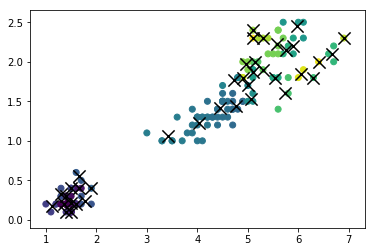

In [12]:
document = [[pl, pw] for pl,pw in zip(list(data.petal_length), list(data.petal_width))]

best_accuracy = -1
best_centr = None
y_pred = []
best_label = []
best_k = 0

inicio = time()
for _ in range(30):
    for K in range(1, 50):
        y_pred, centroids = kmeans(document, 50, euclidianDistance)

    #     accuracy = metrics.adjusted_rand_score(y_true, y_pred)
        try:
            accuracy = metrics.v_measure_score(y_true, y_pred)
        except:
            print(y_pred)


        if accuracy >= best_accuracy:
            best_accuracy = accuracy
            best_centr = centroids
            best_k = K
            best_label = y_pred
            
final = time()
    
print(f"Melhor valor para o K:   {best_k}\nObtendo uma acurácia de: {best_accuracy} (v_measure_score) \nTempo: {final-inicio}")
plotter(document, best_centr, best_label)
